# seq2seq의 문제점

In [ ]:
import cv2
from PIL import Image

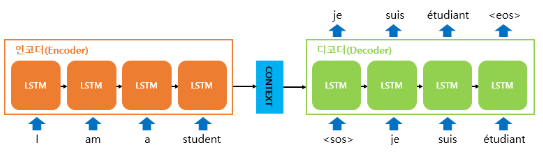

In [ ]:
img = cv2.imread("/content/drive/MyDrive/시퀀스투시퀀스.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

* 시퀀스투시퀀스 모델은 여러 시점의 입력 벡터를 단지 하나의 벡터로 축소시킨다. 고정된 크기의 벡터로 축소시키기 때문에 정보 손실이 일어날 수 있다.
* 문장이 길어지면 RNN은 처음 나온 단어들의 정보를 많이 가지고 있지 않는다. LSTM,GRU가 근본적으로 이런 문제를 해결해주지는 못 한다.

# Attention(어텐션)

* 시퀀스투시퀀스 모델의 대한 해결책으로 어텐션이라는 기법이 등장했다.
* 시퀀스투시퀀스는 문장이 길어지면 문맥 벡터에서 정보 손실이 많이 일어난다. 따라서 디코더가 단어를 예측할 때 마다 인코더에서 참고해야할 단어가 무엇인지 attention(집중) 하는 것이 핵심이다.

* 어텐션을 표현하는 방법은 Attention(Q,K,V)이다.
Q = query
K = Key
V = value 를 의미한다.

* 이를 해석해보면 Q와 가장 관련있는 K를 찾아서 그에 해당하는 V를 내보내주겠다는 것을 의미한다.

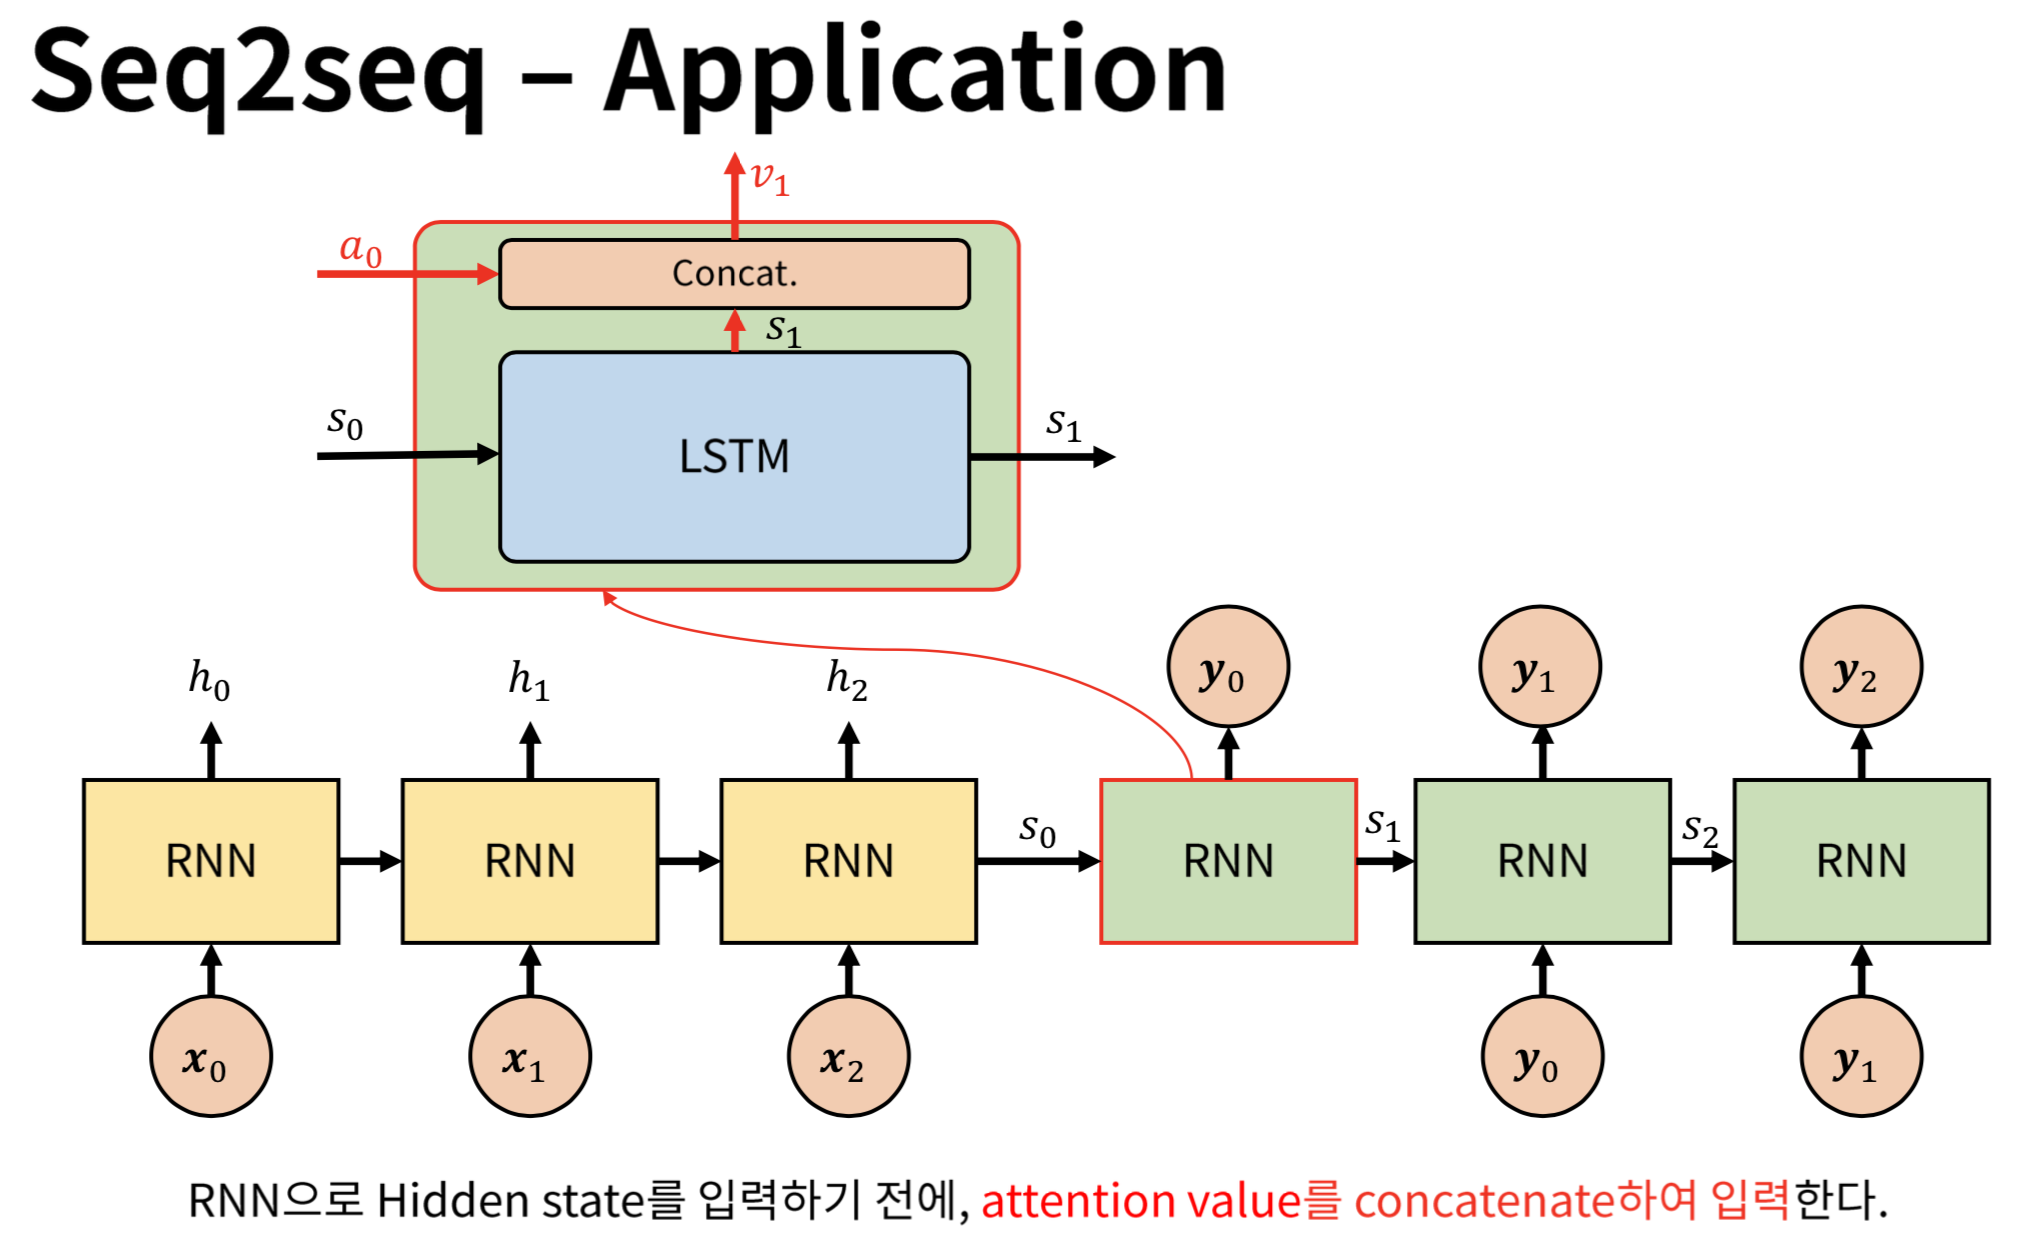

In [ ]:
img = cv2.imread("/content/drive/MyDrive/어텐션 원리.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

## 어텐션 스코어

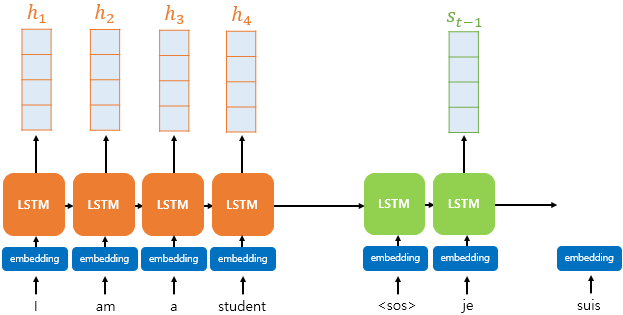

In [ ]:
img = cv2.imread("/content/drive/MyDrive/어텐션 스코어 이미지.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

* encoder의 입력 단어들이 임베딩 layer과 rnn계열 모델을 거친 후 은닉상태가 나옴
* 은닉상태에는 각 단어들의 대한 정보가 담겨있음.
* 바다나우 어텐션에서는 디코더의 t-1 시점의 은닉 상태가 인코더의 은닉상태 중 어떤 부분을 참고해야지 t시점에서 잘 예측을 할 수 있을지 고려함. (t-1시점이 고려하는 이유는 마지막에)

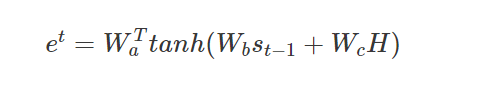

In [ ]:
img=cv2.imread("/content/drive/MyDrive/어텐션 스코어 식.PNG")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

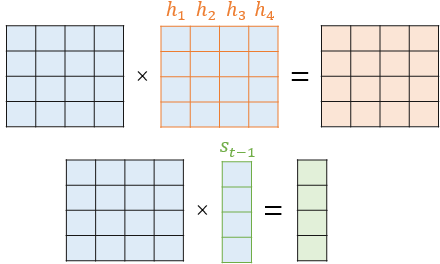

In [ ]:
img = cv2.imread("/content/drive/MyDrive/어텐션 스코어 가중치.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

* 행렬 연산을 하기 위해서 인코더의 은닉상태를 합쳐 계산을 함.
* W_a , W_b, W_c는 학습이 되는 가중치 임.
* 즉 실제 값을 통해 loss를 줄이는 방식으로 가중치를 학습하고 적절한 은닉상태를 선택할 수 있도록 해줌.

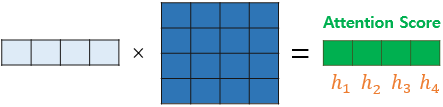

In [ ]:
img = cv2.imread("/content/drive/MyDrive/어텐션 스코어 유사도.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

# 어텐션 분포

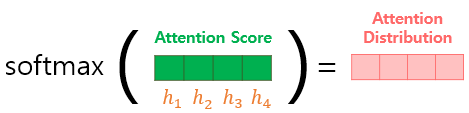

In [ ]:
img = cv2.imread("/content/drive/MyDrive/어텐션 분포.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

* 위에서 구한 어턴션 스코어를 softmax 함수를 거쳐 총합 1이되도록 하여 가중치를 만듦.

# 어텐션 값

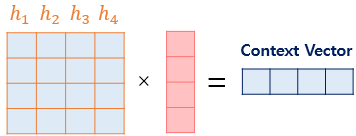

In [ ]:
img = cv2.imread("/content/drive/MyDrive/어텐션 값.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

* 위에서 만든 가중치 값과 은닉상태를 행렬 곱을 통하여 context vector를 생성함.
* 가중치 값과 곱해주면서 context vector에는 인코더의 은닉상태 중 가중치가 높은 단어에 대한 정보가 많을 것임.

# 어텐션 입력 값

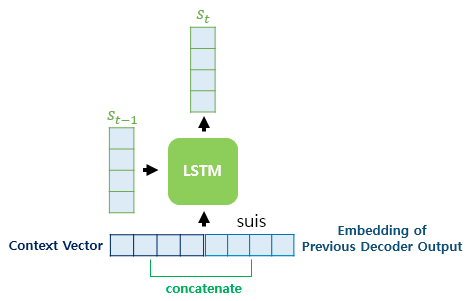

In [ ]:
img = cv2.imread("/content/drive/MyDrive/어텐션 입력 연결.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Image.fromarray(img)

* 위에서 구한 context vector를 디코더의 t시점의 임베딩 층을 거친 값과 concatenate 하여 LSTM, RNN, GRU등의 입력값으로 들어감.

* t시점의 입력 값으로 같이 넣어주기 때문에 t-1시점이 인코더의 은닉상태를 찾는 것 같음. 루옹의 닷 프로덕션 어텐션은 context vector를 t시점의 은닉상태와 concatenate하기 때문에 t시점의 은닉상태가 인코더의 은닉상태를 찾음.

# 어텐션을 이용한 영어 프랑스어 번역

In [ ]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import random

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import TensorDataset , DataLoader


In [ ]:
http = urllib3.PoolManager()
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [ ]:
num_samples = 33000

In [ ]:
def to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):

  sent = to_ascii(sent.lower())
  sent = re.sub(r"([?.!,¿])", r" \1", sent)
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [ ]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      src_line, tar_line, _ = line.strip().split('\t')
      src_line = [w for w in preprocess_sentence(src_line).split()]
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

In [ ]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


In [ ]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [ ]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4637, 프랑스어 단어 집합의 크기 : 8115


In [ ]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [12870 21918 17224 ... 28767 11131  5084]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 3300


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
x_input = encoder_input_train[:128]
y_input = decoder_input_train[:128]
y_target = decoder_target_train[:128]

x_input = torch.LongTensor(x_input)
y_input = torch.LongTensor(y_input)
y_target = torch.LongTensor(y_target)

In [ ]:
x_input = x_input.permute(1,0)
y_input = y_input.permute(1,0)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_dim,emb_dim,enc_hid_dim,dec_hid_dim):
    super().__init__()

    self.embedding_layer = nn.Embedding(input_dim,emb_dim)
    self.rnn_layer = nn.GRU(emb_dim,enc_hid_dim,bidirectional=True,batch_first=True)
    self.fc_layer = nn.Linear(enc_hid_dim * 2 ,dec_hid_dim)

  def forward(self,x_input):
    embedded = self.embedding_layer(x_input)
    outputs ,hidden = self.rnn_layer(embedded)
    hidden = torch.tanh(self.fc_layer(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1)))

    return outputs,hidden


In [ ]:
class Decoder(nn.Module):
  def __init__(self,output_dim,emb_dim,enc_hid_dim,dec_hid_dim,attention):
    super().__init__()
    self.attention = attention

    self.embedding_layer = nn.Embedding(output_dim,emb_dim)
    self.rnn_layer = nn.GRU((enc_hid_dim * 2) + emb_dim,dec_hid_dim,batch_first=True)
    self.fc_layer = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim,output_dim)

  def forward(self,input,hidden,encoder_outputs):
    input = input.unsqueeze(1)
    embedded = self.embedding_layer(input)

    attention_value = self.attention(hidden,encoder_outputs)
    attention_value = attention_value.unsqueeze(1)
    weighted = torch.bmm(attention_value,encoder_outputs)

    rnn_input = torch.cat((embedded,weighted),dim=2)
    output,hidden = self.rnn_layer(rnn_input,hidden.unsqueeze(0))

    assert (output.squeeze() == hidden.squeeze()).all()

    embedded = embedded.squeeze(1)
    output = output.squeeze(1)
    weighted = weighted.squeeze(1)

    prediction  =self.fc_layer(torch.cat((output,weighted,embedded),dim=1))

    return prediction , hidden.squeeze(0)

In [ ]:
class Attention(nn.Module):
  def __init__(self,enc_hid_dim,dec_hid_dim):
    super().__init__()

    self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim,dec_hid_dim)
    self.v = nn.Linear(dec_hid_dim,1,bias=False)

  def forward(self,hidden,encoder_outputs):
    batch_size = encoder_outputs.shape[0]
    x_input_len = encoder_outputs.shape[1]

    hidden = hidden.unsqueeze(1).repeat(1,x_input_len,1)

    energy = torch.tanh(self.attn(torch.cat((hidden,encoder_outputs),dim=2)))

    attention = self.v(energy).squeeze(2)

    return f.softmax(attention,dim=1)


In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder):
    super().__init__()

    self.encoder = encoder 
    self.decoder = decoder

  def forward(self,x_input,y_input,teacher_forcing_ratio=1):

    batch_size = x_input.shape[0]
    y_input_len = y_input.shape[1]

    y_input_vocab_size = 8115

    outputs = torch.zeros(y_input_len,batch_size,y_input_vocab_size).to(device)

    encoder_outputs , hidden = self.encoder(x_input)

    input = y_input[:,0]

    for t in range(1,y_input_len):
      output, hidden = self.decoder(input,hidden,encoder_outputs)
      outputs[t] = output

      teacher_force = random.random() < teacher_forcing_ratio

      top1 = output.argmax(dim=1)

      input = y_input[:,t] if teacher_force else top1

    return outputs

In [ ]:
input_dim = src_vocab_size
emb_dim = 256
enc_hid_dim = 512
dec_hid_dim = 512
output_dim = tar_vocab_size

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(enc_hid_dim,dec_hid_dim).to(device)
dec = Decoder(output_dim,emb_dim,enc_hid_dim,dec_hid_dim,attention).to(device)
enc = Encoder(input_dim,emb_dim,enc_hid_dim,dec_hid_dim).to(device)
model = Seq2Seq(enc,dec).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
encoder_input_train = torch.LongTensor(encoder_input_train)
decoder_input_train = torch.LongTensor(decoder_input_train)
decoder_target_train = torch.LongTensor(decoder_target_train)

encoder_input_test = torch.LongTensor(encoder_input_test)
decoder_input_test = torch.LongTensor(decoder_input_test)
decoder_target_test = torch.LongTensor(decoder_target_test)

In [ ]:
tensor_train = TensorDataset(encoder_input_train,decoder_input_train,decoder_target_train)
tensor_test = TensorDataset(encoder_input_test,decoder_input_test,decoder_target_test)

In [ ]:
train_loader = DataLoader(tensor_train,batch_size=128,shuffle=True,drop_last=True)
test_loader = DataLoader(tensor_test,batch_size=128,shuffle=False)

In [ ]:
for epoch in range(50):
  avg_loss = 0
  for batch in train_loader:
    x_input = batch[0].to(device)
    y_input = batch[1].to(device)
    y_target = batch[2].to(device)

    outputs = model(x_input,y_input)
    loss = criterion(outputs[1:].view(-1,8115),y_target[:,:-1].permute(1,0).reshape([-1]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss / len(train_loader)

  print("epoch : {} 일때 loss : {}". format(epoch+1,avg_loss))

epoch : 1 일때 loss : 1.1833375692367554
epoch : 2 일때 loss : 0.5153770446777344
epoch : 3 일때 loss : 0.3294616639614105
epoch : 4 일때 loss : 0.25319796800613403
epoch : 5 일때 loss : 0.20928378403186798
epoch : 6 일때 loss : 0.18438197672367096
epoch : 7 일때 loss : 0.1666368842124939
epoch : 8 일때 loss : 0.15685538947582245
epoch : 9 일때 loss : 0.1494540423154831
epoch : 10 일때 loss : 0.1427796483039856
epoch : 11 일때 loss : 0.1412389576435089
epoch : 12 일때 loss : 0.13595695793628693
epoch : 13 일때 loss : 0.13391272723674774
epoch : 14 일때 loss : 0.13226880133152008
epoch : 15 일때 loss : 0.1307811439037323
epoch : 16 일때 loss : 0.1286315768957138
epoch : 17 일때 loss : 0.12815740704536438
epoch : 18 일때 loss : 0.12612834572792053
epoch : 19 일때 loss : 0.12526185810565948
epoch : 20 일때 loss : 0.12372373789548874
epoch : 21 일때 loss : 0.12388627976179123
epoch : 22 일때 loss : 0.12152279168367386
epoch : 23 일때 loss : 0.12193317711353302
epoch : 24 일때 loss : 0.12106001377105713
epoch : 25 일때 loss : 0.12011188268

In [ ]:
def decode_sequence(input_seq,output_seq):

  outputs = model(input_seq,output_seq,0)
  sentences = []
  for index in input_seq.squeeze().cpu().numpy():
    if index == 0:
      continue

    else :
      sentence = index_to_src[index]
      sentences.append(sentence)

  target_sentences = []
  for index in output_seq.squeeze().cpu().numpy():
    if (index == 0) or (index==2):
      continue

    else :
      sentence = index_to_tar[index]
      target_sentences.append(sentence)

  translate_sentences = []
  for index in outputs[1:].squeeze(1).argmax(dim=1).cpu().numpy():
    
    if index == 3:
      break

    if (index == 0) or (index==2):
      continue

    else :
      sentence = index_to_tar[index]
      translate_sentences.append(sentence)

  return sentences , target_sentences,translate_sentences



In [ ]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index:seq_index+1]
  output_seq = decoder_input_train[seq_index:seq_index+1]
  input_seq = input_seq.to(device)
  output_seq = output_seq.to(device)
  sentences , target_sentences, translate_sentences = decode_sequence(input_seq,output_seq)
  sentences = " ".join(sentences)
  target_sentences = " ".join(target_sentences)
  translate_sentences = " ".join(translate_sentences)

  print("\n문장을 번역 중입니다.\n")  
  print("입력문장 : {}".format(sentences))
  print("정답문장 : {}".format(target_sentences))
  print("번역문장 : {}".format(translate_sentences))
  
  



문장을 번역 중입니다.

입력문장 : who are these men ?
정답문장 : qui sont ces hommes ?
번역문장 : qui sont ces hommes ?

문장을 번역 중입니다.

입력문장 : i need to do that .
정답문장 : j ai besoin de faire ca .
번역문장 : j ai besoin de faire ca .

문장을 번역 중입니다.

입력문장 : tom is tireless .
정답문장 : tom est infatigable .
번역문장 : tom est infatigable .

문장을 번역 중입니다.

입력문장 : i need time .
정답문장 : j ai besoin de temps .
번역문장 : j ai besoin de temps .

문장을 번역 중입니다.

입력문장 : tom looks annoyed .
정답문장 : tom a l air agace .
번역문장 : tom a l air enerve .


In [ ]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index:seq_index+1]
  output_seq = decoder_input_test[seq_index:seq_index+1]
  input_seq = input_seq.to(device)
  output_seq = output_seq.to(device)
  sentences , target_sentences, translate_sentences = decode_sequence(input_seq,output_seq)
  sentences = " ".join(sentences)
  target_sentences = " ".join(target_sentences)
  translate_sentences = " ".join(translate_sentences)

  print("\n문장을 번역 중입니다.\n")  
  print("입력문장 : {}".format(sentences))
  print("정답문장 : {}".format(target_sentences))
  print("번역문장 : {}".format(translate_sentences))
  


문장을 번역 중입니다.

입력문장 : that was quick .
정답문장 : c etait rapide .
번역문장 : c etait rapide .

문장을 번역 중입니다.

입력문장 : do you live alone ?
정답문장 : vis tu seul ?
번역문장 : vivez vous seules ?

문장을 번역 중입니다.

입력문장 : are we prepared ?
정답문장 : y sommes nous pretes ?
번역문장 : sommes nous pretes ?

문장을 번역 중입니다.

입력문장 : it s a great start .
정답문장 : c est un grand debut .
번역문장 : c est un grand comment .

문장을 번역 중입니다.

입력문장 : help me out here .
정답문장 : aidez moi a sortir d ici !
번역문장 : aide moi a sortir d ici !
